<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/ARTMO_BV_GPR_model_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the required libraries.

In [ ]:
!pip install geemap
!pip install earthengine-api

Import ee library.

In [ ]:
import ee
import geemap
from ipyleaflet import *
from ipywidgets import Label
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Authenticate and initialize ee

In [ ]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=YYhHF3vSXxWWwYTIyl0KlRVnx3_-c-hL3QD6otPwgZU&tc=XhruApV7iJf1kAvzFC1ZpXy5usgnF3ghNbjtWb60-AY&cc=BzhIzy7oqZgg0C-9d5acL6c6xURtk8tPeA6S86ATW3s

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavddwblr7BwHo2F48E1_-o3NURRDbSz1Amcx4cUqe8gishFwgtRrX2JA

Successfully saved authorization token.


Select the Area of Interest

In [ ]:
Map = geemap.Map()
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Spain'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,6)

Map

Map(center=[40.35722509547827, -3.499564837147696], controls=(WidgetControl(options=['position', 'transparent_…

Retrieve the ROI from the map

In [ ]:
feature = Map.draw_last_feature
roi = feature.geometry()

In [ ]:
# Roi Gabriel
roi = ee.Geometry.Polygon([[[-62.649809132123174, -39.38875854378754],[-62.649809132123174, -39.408589872607514],[-62.615562687421026, -39.408589872607514],
          [-62.615562687421026, -39.38875854378754]]])

Import models

In [ ]:
!cp /content/drive/MyDrive/geePythonModels/BOAModelsV2.py .

import BOAModelsV2

Set variable model to process

In [ ]:
#['LAIGreen', 'Cab', 'Cm', 'Cw', 'FVC', 'LAI', 'laiCab', 'laiCm', 'laiCw', 'LAIBrown']
currentVegIndex = 'LAIBrown'
currentModel = BOAModelsV2.models[currentVegIndex]

Functions

In [ ]:
# Masking function for water and cloud
def maskS2cloud_and_water(image):
  not_water = image.select('SCL').neq(6);
  not_cloud_low = image.select('SCL').neq(7);
  not_cloud_medium = image.select('SCL').neq(8);
  not_cloud_high = image.select('SCL').neq(9);
  not_cirrus = image.select('SCL').neq(10);

  qa = image.select('QA60');
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(not_water).And(not_cloud_low)
          .And(not_cloud_medium).And(not_cloud_high).And(not_cirrus))
  return image.updateMask(mask).divide(currentModel['scaleFactor']).copyProperties(qa).set('system:time_start', qa.get('system:time_start'))

# Auxiliar function for mapping : (1..n) -> (B1..Bn)
def band_names(element):
  bandName = ee.String('B').cat(ee.Number(element).int().format())
  return bandName

def addDoy(image):
  doy = image.date().getRelative('day', 'year')
  doyBand = ee.Image.constant(doy).uint16().rename('doy')
  return image.addBands(doyBand)

# Veg index GPR for mean prediction
def veg_index_GPR(image_orig):

  # Create List of Bands of Dimension n (Xtrain[n,n])
  XTrain_dim = currentModel['X_train'].length().get([0]).getInfo();

  band_sequence   = (ee.List.sequence(1, XTrain_dim)
                    .map(band_names));

  # Create a list of band names for flattening operation
  im_norm_ell2D_hypell = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).multiply(ee.Image(currentModel['hyp_ell'])).toArray().toArray(1);

  im_norm_ell2D = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).toArray().toArray(1);

  PtTPt  = im_norm_ell2D_hypell.matrixTranspose().matrixMultiply(im_norm_ell2D).arrayProject([0]).multiply(-0.5);

  PtTDX  = ee.Image(currentModel['X_train']).matrixMultiply(im_norm_ell2D_hypell).arrayProject([0]).arrayFlatten([band_sequence]);

  arg1   = PtTPt.exp().multiply(currentModel['hyp_sig']);

  k_star = PtTDX.subtract(ee.Image(currentModel['XDX_pre_calc']).multiply(0.5)).exp().toArray();

  mean_pred = k_star.arrayDotProduct(ee.Image(currentModel['alpha_coefficients']).toArray()).multiply(arg1);

  mean_pred = mean_pred.toArray(1).arrayProject([0]).arrayFlatten([[currentModel['veg_index']]]);

  mean_pred = mean_pred.add(currentModel['mean_model']);

  # Mask values equal or less than 0
  mean_pred = mean_pred.updateMask(mean_pred.gt(0))

  image_orig = image_orig.addBands(mean_pred)

  return image_orig.select(currentModel['veg_index'])

def mask_gt(image):
  veg_index_mask = image.select(currentModel['veg_index']).gt(0).rename('veg_index_mask')
  return image.addBands(veg_index_mask).select('veg_index_mask')

def addVariables(image):
  date = ee.Date(image.get("system:time_start"))
  years = date.difference(ee.Date('1970-01-01'),'days')
  return image.addBands(ee.Image(years).rename('t').float())

Dates of interest

In [ ]:
start_date = '2018-01-01'
end_date = '2021-12-31'

Create the initial image collection with the spectral bands

In [ ]:
S2collection_ini = ee.ImageCollection('COPERNICUS/S2_SR')\
                   .filterBounds(roi)\
                   .filterDate(start_date,end_date)\
                   .map(maskS2cloud_and_water)\
                   .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])

Create the predicted mean image collection

In [ ]:
targetCollection =  S2collection_ini.map(veg_index_GPR).select(currentModel['veg_index'])

In [ ]:
def extract_ts(roi, col, band):
    """ Constructs a dataframe with the time series for the ROI with the image
        collection.

        Parameters
        ----------
        roi : ee.Geometry, Region of interest

        col : ee.ImageCollection

        band : string, Name of the band to retrieve

        Returns
        ------
        A pandas dataframe

    """

    # Auxiliar function to replace the null values with custom value(-9999)
    # so we do not lose the masked values.
    def set_NAN(key,val):
        return ee.List([val, -9999]).reduce(ee.Reducer.firstNonNull())

    # Retrieve the mean value of the band in the roi and the date of the image
    def get_ts(image):
        stat = image.select([band]).reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry= roi,
            scale= 20,
            bestEffort= True
        )
        stat = stat.map(set_NAN)
        return ee.Feature(roi, stat).set({'millis': image.date().millis()})

    # List of features containing the reduced value and the date
    ts = col.map(get_ts)

    # Lists of values and dates
    y = ts.aggregate_array(band).getInfo()
    dates_ms = ts.aggregate_array('millis').getInfo() # Date in ms
    x = [datetime.fromtimestamp(d//1000.0) for d in dates_ms] # Formatted date

    # Dictionary that will feed the pandas dataframe
    dict = {'date': x, band: y}
    # Contruct the df and replace the custom NaN values(-9999) with np.nan
    df = pd.DataFrame(dict).replace(-9999, np.nan)
    return df

Extract the ts and plot it.

In [ ]:
df_S2 = extract_ts(roi, targetCollection, currentModel['veg_index'])
df_S2

,date,LAI_BROWN
0,2018-12-13 14:13:29,6.635910
1,2018-12-18 14:13:26,7.257883
2,2018-12-23 14:13:31,5.973422
3,2018-12-28 14:13:28,6.142072
4,2019-01-02 14:13:33,5.207300
...,...,...
217,2021-12-07 14:13:30,5.225921
218,2021-12-12 14:13:34,NaN
219,2021-12-17 14:13:29,4.547344
220,2021-12-22 14:13:36,5.690158


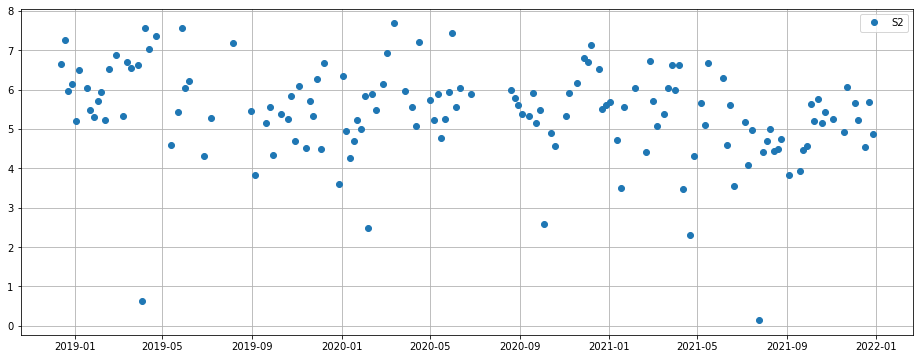

In [ ]:
plt.figure(figsize= (16,6))
plt.plot(df_S2['date'], df_S2[currentModel['veg_index']], 'o', label='S2')
plt.grid(True)
plt.legend()

Export parameters

In [ ]:
# GEE user
user = 'msalinero85'

Export the image collection as an image collection asset.

Create the ee.ImageCollection asset.

In [ ]:
# Custom name given to the collection
assetColName = 'test_col_' + currentVegIndex
# Construct the id
assetColId = 'users/{}/{}'.format(user,assetColName)
# Create the empty ee.ImageCollection asset
ee.data.createAsset({'type': 'ImageCollection'}, assetColId)

Launch the tasks.

In [ ]:
n = targetCollection.size().getInfo()
colList = targetCollection.toList(n)

taskList = []

for i in range(n):

  img = ee.Image(colList.get(i));
  id = img.id().getInfo() + '_' + currentVegIndex

  region = img.geometry();

  task_config = {
    'image': img,
    'description': id,
    'assetId': assetColId + '/' + id,
    'region': region,
    'scale': 20,
    'maxPixels': 1e13
  }

  task = ee.batch.Export.image.toAsset(**task_config)

  task.start()

  taskList.append(task)

Export the image collection to a Google Drive folder

In [ ]:
downloadFolder = 'geeTestDownload'

n = targetCollection.size().getInfo()
colList = targetCollection.toList(n)

taskList = []

for i in range(n):

  img = ee.Image(colList.get(i));
  id = img.id().getInfo() + '_' + currentVegIndex

  region = img.geometry()

  task_config = {
    'image': img,
    'description': id,
    'folder': downloadFolder,
    'fileNamePrefix': id,
    'region': region,
    'scale': 20,
    'maxPixels': 1e13
  }

  task = ee.batch.Export.image.toDrive(**task_config)

  task.start()

  taskList.append(task)

Check the status of the tasks

In [ ]:
print('Number of tasks:' + str(len(taskList)))

for t in taskList:
  desc = t.status()['description']
  state = t.status()['state']

  print('Task {} is {}'.format(desc,state))

Cancel the tasks

In [ ]:
"""
for t in taskList:
 t.cancel()
 desc = t.status()['description']
 state = t.status()['state']

 print('Task {} is {}'.format(desc,state))
"""

In [ ]:
# Get root folder from assets
folder = ee.data.getAssetRoots()[0]['id']
# Name of the collection
col = 'test_col_LAI'
# Id of the asset
colId = folder + '/' + col
# Retrieve the list of images
image_dict_list = ee.data.listAssets({'parent': colId})['assets']
[d['id'] for d in image_dict_list if 'id' in d]